# OEAS895_Project_Einarsson

This project will attempt to model the ratio of dinoflagellates to diatoms, using variables that were collected by the ships flow through system sensors(fluorometer, thermistor), salinity (ctd) and a weather buoy (wind speed, wind direction, air temperature, water temperature). 
The purpose of this code is for prelimanary data analysis and visualization to get a sense of what the data looks like.
Steps that needed to be take before importing into python script:
 - combining data files imported from fluorometer
     - command used: grep "^fluoro" * > fluro_turner_wHeader.txt
     - issues that came up
         - rogue spaces
         - command used: regex to replace rogue spaces for ex. find (\w)  (\w) replace with $1\t$2
             - And by changing the amount of spaces betweeh (\w) allowed for all rogue spaces to be converted to tabs. Thus the file lined up nicely for import.

Other issues encountered:
- creating a datenum variable
     - this was necessary to create a variable to easily find any datapoints corresponding to a sampling time. So that I was able to group fluorometer variables within 15 minutes of time of when my own samples were collected. These variables were then averaged to give a good representation of the water that was sampled for my own sequencing data.
        - this datenum was calculated using a code from online:
            - https://stackoverflow.com/questions/32991934/equivalent-function-of-datenumdatestring-of-matlab-in-python
- the temporal range of the dataset is not large. It is over the span of a week and a half but the purpose of this project is to see if we are able to model the ratio of dinoflagellates to diatoms using environmental variables. Hopefully, the results will be positive and we can expand this project to include more temporally variable data.

The following code will be explained in detail either before or in each cell, but the process (Part 1 and 2 aren't always in order in the code, but is outlined for explanation) is outlined here:
# Part 1: importing the data from the various sources
 - Underway fluorometer
     - Data downloaded from R2R
         - https://www.rvdata.us/search/cruise/SKQ201713S;
 - NOAA buoy located at 70°24'0" N 148°31'36" W
     - Data downloaded from NOAA (National Data Buoy Center)
     - https://www.ndbc.noaa.gov/view_text_file.php?filename=prda2h2017.txt.gz&dir=data/historical/stdmet/
 - Salinity measurements
     - Data collected by CTD at each station 
 - Sequencing data, collected at each station and then sequenced. Data imported here is cleaned up and run through our lab's pipeline. (Includes programs CLC Genomics, and MED (Eren et al 2014))
 - Import and align this data with the ships ELOG collected from R2R(https://www.rvdata.us/search/cruise/SKQ201713S), which has the coordinates for each station sampled.
 - Remote sensing data, sea surface temperature and salinity obtained from NASA.
     - SST: https://podaac-tools.jpl.nasa.gov/drive/files/allData/modis/L3/terra/4um/v2019.0/9km/daily/2017
     - SSS: https://podaac-tools.jpl.nasa.gov/drive/files/allData/smap/L3/RSS/V4/8day_running/SCI/2017
     - Each file was opend in SeaDAS and a value that corresponded to the station coordinate and day sampled was hand picked. Only data was collected if there was a pixel within a quarter of a degree and of course, if there were no clouds and data was available
         - The files are in the github project folder SST, and SSS
     - The drawback of having samples from the high Arctic is that measurements of SST and SSS by remote sensing are hard to come by due to coverage and weather. 

# Part 2: calculating new variables needed for data analysis or the model itself
 - Create datenum variable as explained above
 - Sum the dinoflagellates and diatoms in the sequencing data for each station
     - calculate ratio of dinoflagellates/diatoms
 - Combine:
     - Log sheet (RVSikuilaq2017Log_Edited.csv)
     - Fluorometer variables
     - Sequencing data
     - Salinity
     
# Part 3: plotting the variables imported and spatial coverage
 
 - Visualize spatial coverage of data and see if it overlaps with buoy data from Austin Abbott
 - Visualize what the range of the variables being used to train the model look like

In [1]:
#Import packages needed to run code
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Part 1 and 2

In [2]:
#Import datetime
#Copy the function to create the datenum variable from: https://stackoverflow.com/questions/32991934/equivalent-function-of-datenumdatestring-of-matlab-in-python
from datetime import datetime as dt

def datenum(d):
    return 366 + d.toordinal() + (d - dt.fromordinal(d.toordinal())).total_seconds()/(24*60*60)

In [3]:
#Import the log sheet for my own sequencing data. This shows the vessel name, DNA sample number,
#cruise station number (for ELOG) and description of station sampled.
infile = 'RVSikuilaq2017Log_Edited.csv'
SikLog = pd.read_csv(infile, sep = (','))
print SikLog.head()

    Cruise Name  Sample #       Date Time GMT  Station Number   Description
0  R/V Sikuliaq         1  8/29/2017     6:40               1  Test Station
1  R/V Sikuliaq         3  8/30/2017    18:26               5    WPNT 2.2 A
2  R/V Sikuliaq         5  8/30/2017    19:59               7    WPNT 2.4 A
3  R/V Sikuliaq         7  8/30/2017    23:22               9    WPNT 2.6 A
4  R/V Sikuliaq         9  8/30/2017     1:30              11    WPNT 2.8 A


In [4]:
#Make the log sheet into an array to combine date and time columns in order to pass to the 
#datenum function.
myarray = np.asarray(SikLog)
#Initialze list to save each combined date/time row
dateTime = []
#For each row in the log sheet combine the date and time, and save to list
for i in myarray:
    mondayyear = str(i[2])
    time = str(i[3])
    DateTimeComb = ('%s %s') % (mondayyear,time)
    dateTime.append(DateTimeComb)
#Save list into a pandas dataframe and combine with the log sheet data. Then print head to 
#visualize.
dTdf = pd.DataFrame(dateTime,columns = ["DateTime"]) 
combSikdata = pd.concat([SikLog, dTdf], axis=1)
combSikdata.head()

,Cruise Name,Sample #,Date,Time GMT,Station Number,Description,DateTime
0,R/V Sikuliaq,1,8/29/2017,6:40,1,Test Station,8/29/2017 6:40
1,R/V Sikuliaq,3,8/30/2017,18:26,5,WPNT 2.2 A,8/30/2017 18:26
2,R/V Sikuliaq,5,8/30/2017,19:59,7,WPNT 2.4 A,8/30/2017 19:59
3,R/V Sikuliaq,7,8/30/2017,23:22,9,WPNT 2.6 A,8/30/2017 23:22
4,R/V Sikuliaq,9,8/30/2017,1:30,11,WPNT 2.8 A,8/30/2017 1:30


The following cell will be repeated for data other than the log sheet (fluorometer and buoy data), and here I iterate through the DateTime column (pictured above) and feed into datenum function to return the Matlab equivelent of the datenum variable. 

In [5]:
#Calculate length of column to iterate through
col_len = len(combSikdata[['DateTime']])
#Initialize list to save each iteration of the datenum calculation
datenum_Sik = []
#For loop to calculate the datenum variable for each row
for i in range(0,col_len,1):
    d = dt.strptime(combSikdata.iloc[i]['DateTime'],'%m/%d/%Y %H:%M')
    #print d
    dn = datenum(d)
    #print dn
    datenum_Sik.append(dn)
#Make the datenum list into a pandas datafram and concatanate with the Sikuliaq log sheet.
#Then visualize to confirm everything looks good.
dTdf = pd.DataFrame(datenum_Sik,columns = ["Datenum"]) 
Sikdata_datenum = pd.concat([combSikdata, dTdf], axis=1)
Sikdata_datenum.tail()

,Cruise Name,Sample #,Date,Time GMT,Station Number,Description,DateTime,Datenum
39,R/V Sikuliaq,81,9/9/2017,6:59,138,WPNT 2.10 E,9/9/2017 6:59,736947.290972
40,R/V Sikuliaq,82,9/9/2017,8:15,140,WPNT 2.8 E,9/9/2017 8:15,736947.343750
41,R/V Sikuliaq,84,9/9/2017,9:58,142,WPNT 2.6 E,9/9/2017 9:58,736947.415278
42,R/V Sikuliaq,86,9/9/2017,11:23,144,WPNT 2.45 E,9/9/2017 11:23,736947.474306
43,R/V Sikuliaq,88,9/9/2017,13:45,146,WPNT 2.3 E,9/9/2017 13:45,736947.572917


The following cell reads in the ELOG for the cruise. In the table above, the station number refers to each station sampled. However, WPNT 2.10, for example, was sampled multiple times. Hence, 2.10 E which means it was the 5th time it was sampled. Each time a station was sampled it was given a unique station number. The purpose of reading in the ELOG is to get the coordinates for each station. 

In [6]:
#Read in the ELOG file and create pandas dataframe
infile = 'R2R_ELOG_skq201713s_FINAL_EVENTLOG_20180913_174843.csv'
Elog = pd.read_csv(infile, sep = (','))
#Sort the ELOG based on station number. It was out of order sometime, reason probably
#only known to those who were on the ship.
Elog['Station'] = pd.to_numeric(Elog['Station'])
Elog = Elog.sort_values(by=["Station"])

In [7]:
#Read in the NOAA buoy data and create pandas dataframe
infile = 'Buoy_NOAA_data.txt'
Buoydata = pd.read_csv(infile,sep = "\t")
print Buoydata.head()
#Read in fluorometer data and create pandas dataframe
infile = 'fluro_turner_wHeader.txt'
FluoroSensor = pd.read_csv(infile,sep="\t")
print FluoroSensor.head()

     YY  MM  DD  hh  mm  WDIR  WSPD   GST  WVHT   DPD   APD  MWD    PRES  \
0  2017   1   1   0   6   999  99.0  99.0  99.0  99.0  99.0  999  1021.2   
1  2017   1   1   0  12   999  99.0  99.0  99.0  99.0  99.0  999  1021.1   
2  2017   1   1   0  18   999  99.0  99.0  99.0  99.0  99.0  999  1020.9   
3  2017   1   1   0  24   999  99.0  99.0  99.0  99.0  99.0  999  1020.9   
4  2017   1   1   0  30   999  99.0  99.0  99.0  99.0  99.0  999  1020.8   

   ATMP   WTMP   DEWP   VIS  TIDE  
0 -10.6  999.0  999.0  99.0  99.0  
1 -10.6  999.0  999.0  99.0  99.0  
2 -10.5  999.0  999.0  99.0  99.0  
3 -10.4  999.0  999.0  99.0  99.0  
4 -10.3  999.0  999.0  99.0  99.0  
                                           Log_Name  \
0  fluoro_turner-c6.20170825T1907Z:fluoro_turner-c6   
1  fluoro_turner-c6.20170825T1907Z:fluoro_turner-c6   
2  fluoro_turner-c6.20170825T1907Z:fluoro_turner-c6   
3  fluoro_turner-c6.20170825T1907Z:fluoro_turner-c6   
4  fluoro_turner-c6.20170825T1907Z:fluoro_turner-c6 

In [8]:
#As down above for the ELOG, the date and time columns are concatanated and saved into a 
#list. Then made into a dataframe and added to the fluorometer variables
myarray = np.asarray(FluoroSensor)
dateTime = []
for i in myarray:
    ymd = str(i[2])
    hms = str(i[3])
    DateTimeComb = ('%s %s') % (ymd,hms)
    dateTime.append(DateTimeComb)
dTdf = pd.DataFrame(dateTime,columns = ["DateTime"]) 
combFluoroSensor = pd.concat([FluoroSensor, dTdf], axis=1)

# The following cell will take a couple of minutes.. Sorry

The following cell creates a datenum variable for each row. This file is very large as the sensor sampled every second.

In [9]:
#Calculate length of column to iterate through
#Initialize list to save each iteration of the datenum calculation
#Then iterate through, calculate datenum variable, append to fluorometer data and visualize.
col_len = len(combFluoroSensor[['C6_Date']])
datenum_Fluoro = []
for i in range(0,col_len,1):
    #print i
    #print combFluoroSensor.iloc[i]['DateTime']
    d = dt.strptime(combFluoroSensor.iloc[i]['DateTime'],' %m/%d/%y %H:%M:%S')
    dn = datenum(d)
    #print dn
    datenum_Fluoro.append(dn)
dTdf = pd.DataFrame(datenum_Fluoro,columns = ["Datenum"]) 
Fluorodata_datenum = pd.concat([combFluoroSensor, dTdf], axis=1)
Fluorodata_datenum.tail()

,Log_Name,Log_time,C6_Date,C6_Time,Phycoeryth(RFU),CDOM(RFU),Chlorophyll_a(RFU),Crude Oil(RFU),Turbidity(RFU),Depth(m),Temp(C),DateTime,Datenum
1390600,fluoro_turner-c6.20170910T0000Z:fluoro_turner-c6,2017-09-10T23:59:55.4733Z,9/10/17,23:58:49,10.52,78.44,26.44,153.28,14.48,11.23,2.98,9/10/17 23:58:49,736948.999178
1390601,fluoro_turner-c6.20170910T0000Z:fluoro_turner-c6,2017-09-10T23:59:56.4706Z,9/10/17,23:58:50,10.52,78.08,25.28,152.56,13.32,11.23,2.98,9/10/17 23:58:50,736948.999190
1390602,fluoro_turner-c6.20170910T0000Z:fluoro_turner-c6,2017-09-10T23:59:57.4709Z,9/10/17,23:58:51,10.52,80.24,26.12,157.56,13.88,11.23,2.98,9/10/17 23:58:51,736948.999201
1390603,fluoro_turner-c6.20170910T0000Z:fluoro_turner-c6,2017-09-10T23:59:58.4719Z,9/10/17,23:58:52,10.52,75.24,28.08,158.08,14.04,11.23,2.98,9/10/17 23:58:52,736948.999213
1390604,fluoro_turner-c6.20170910T0000Z:fluoro_turner-c6,2017-09-10T23:59:59.4718Z,9/10/17,23:58:53,10.52,80.92,27.76,153.72,13.80,11.23,2.99,9/10/17 23:58:53,736948.999225


Following two cells are exactly as the previous datenum calculates above. Except this time for the NOAA buoy data.

In [10]:
myarray = np.asarray(Buoydata)
dateTime = []
for i in myarray:
    year = str(int(i[0]))
    month = str(int(i[1]))
    day = str(int(i[2]))
    hour = str(int(i[3]))
    minute = str(int(i[4]))
    DateTimeComb = ('%s-%s-%s %s:%s') % (year,month,day,hour,minute)
    dateTime.append(DateTimeComb)
dTdf = pd.DataFrame(dateTime,columns = ["DateTime"]) 
combBuoydata = pd.concat([Buoydata, dTdf], axis=1)

In [11]:
col_len = len(combBuoydata[['DateTime']])
datenum_buoy = []
for i in range(0,col_len,1):
    d = dt.strptime(combBuoydata.iloc[i]['DateTime'],'%Y-%m-%d %H:%M')
    #print d
    dn = datenum(d)
    #print dn
    datenum_buoy.append(dn)
dTdf = pd.DataFrame(datenum_buoy,columns = ["Datenum"]) 
Buoydata_datenum = pd.concat([combBuoydata, dTdf], axis=1)

In [12]:
#Some of the variables from the NOAA buoy were NaN's and they are filtered out here. 
#For wind direction, speed as well as atmospheric temperature and water temperature.
Buoydata_datenum = Buoydata_datenum[Buoydata_datenum.WDIR != 999]
Buoydata_datenum = Buoydata_datenum[Buoydata_datenum.WSPD != 99.0]
Buoydata_datenum = Buoydata_datenum[Buoydata_datenum.ATMP != 999]
Buoydata_datenum = Buoydata_datenum[Buoydata_datenum.WTMP != 999]
#Sikdata_datenum.head()

In [13]:
#Here I create a datenum variable that is equivalent to 15 minutes. The date doesn't 
#matter, just the time.

d1 = dt.strptime('12/12/2019 00:00','%m/%d/%Y %H:%M')
d2 = dt.strptime('12/12/2019 00:15','%m/%d/%Y %H:%M')
#print d
dn1 = datenum(d1)
dn2 = datenum(d2)
dt15min =  dn2-dn1

Because the fluorometer sensor sampled every second, I'll be averaging a total 30 minute interval. So each fluorometer variable is averaged over the time that my sample was collected. The buoy sampled every 15 minutes and so the total 30 minute interval gave me a high probability of getting data collected by the buoy almost at the same time my sample was collected.

The following cell combines all of the data imported, cleaned, and analyzed by lining up each station sampled with data from each source (Log sheet, NOAA buoy, Fluorometer, ELOG). 

In [14]:
#Initialize pandas dataframe for the combination of all of the aligned data
Alldata = pd.DataFrame(columns = ['Cruise Name','Sample #','Date','Time GMT','Station Number','Description','DateTime','Datenum','Latitude','Longitude','Phycoeryth(RFU)','CDOM(RFU)','Chlorophyll_a(RFU)','Turbidity(RFU)','Depth(m)','Temp(C)','WDIR','WSPD','ATMP','WTMP'])
tlength = len(Sikdata_datenum['Datenum'])
#For each sample (sequencing sample) iterate through buoydata and fluorometer data to find 
#measurements that correspond to the same time
for i in range(0,tlength,1):
    #Create variables min, max that are the time range that I correspond to a 30 minute
    #window around the time my sample was collected
    numbermin = Sikdata_datenum.iloc[i]['Datenum'] - dt15min
    numbermax = Sikdata_datenum.iloc[i]['Datenum'] + dt15min
    #Get all data from Buoy in the interval
    x = Buoydata_datenum.loc[(Buoydata_datenum['Datenum'] >numbermin ) & (Buoydata_datenum['Datenum'] <numbermax)]
    #Get all data from fluorometer in the interval
    x2 = Fluorodata_datenum.loc[(Fluorodata_datenum['Datenum']>numbermin)&(Fluorodata_datenum['Datenum']<numbermax)]
    #Get station number to find coordinates in the ELOG
    SikStNr = Sikdata_datenum.iloc[i]['Station Number']
    StNr = Sikdata_datenum.iloc[i]['Station Number']
    Elogx = Elog.loc[(Elog['Station'] == StNr)]
    #Add variables from my log sheet (one row at a time)
    Tooappend = list(Sikdata_datenum.iloc[i])
    #Add the latitude and longitude for each sample
    Tooappend.append(np.mean(Elogx['Latitude']))
    Tooappend.append(np.mean(Elogx['Longitude']))
    #Add the variables from the fluorometer (averaged over the 30 minute interval)
    Tooappend.append(np.mean(x2['Phycoeryth(RFU)']))
    Tooappend.append(np.mean(x2['CDOM(RFU)']))
    Tooappend.append(np.mean(x2['Chlorophyll_a(RFU)']))
    Tooappend.append(np.mean(x2['Turbidity(RFU)']))
    Tooappend.append(np.mean(x2['Depth(m)']))
    Tooappend.append(np.mean(x2['Temp(C)']))
    #Add the variables from the NOAA buoy (averaged over the 30 minute interval)
    Tooappend.append(np.mean(x['WDIR']))
    Tooappend.append(np.mean(x['WSPD']))
    Tooappend.append(np.mean(x['ATMP']))
    Tooappend.append(np.mean(x['WTMP']))
    #Add all of this data to the end of the dataframe created before FOR loop
    Alldata.loc[i] = Tooappend
    #print Tooappend
#Visualize the final dataset
Alldata.head()

,Cruise Name,Sample #,Date,Time GMT,Station Number,Description,DateTime,Datenum,Latitude,Longitude,Phycoeryth(RFU),CDOM(RFU),Chlorophyll_a(RFU),Turbidity(RFU),Depth(m),Temp(C),WDIR,WSPD,ATMP,WTMP
0,R/V Sikuliaq,1,8/29/2017,6:40,1,Test Station,8/29/2017 6:40,736936.277778,71.703849,-153.220997,10.656542,194.562955,56040.223839,17.423257,11.334113,6.057174,339.5,9.50,4.200,4.95
1,R/V Sikuliaq,3,8/30/2017,18:26,5,WPNT 2.2 A,8/30/2017 18:26,736937.768056,71.409738,-151.010023,10.630353,161.889267,69.064667,14.778982,11.300145,5.850963,86.0,15.30,3.675,3.90
2,R/V Sikuliaq,5,8/30/2017,19:59,7,WPNT 2.4 A,8/30/2017 19:59,736937.832639,71.340458,-151.042900,10.629323,208.618914,55.620772,16.165439,11.294035,5.733805,88.6,15.80,3.460,3.90
3,R/V Sikuliaq,7,8/30/2017,23:22,9,WPNT 2.6 A,8/30/2017 23:22,736937.973611,71.243108,-151.113516,10.630330,206.008998,43.946525,16.616810,11.294426,5.733710,84.6,16.48,2.900,3.90
4,R/V Sikuliaq,9,8/30/2017,1:30,11,WPNT 2.8 A,8/30/2017 1:30,736937.062500,71.153532,-151.176501,10.638635,156.044365,58.636307,15.506794,11.300834,5.887717,292.0,8.00,3.460,4.72


In [15]:
#Read in salinity from the CTD casts. This is concatanated with the data in the cell above
infile = 'Sik_Sal.csv'
SikLog = pd.read_csv(infile, sep = (','))
Alldata = pd.concat([Alldata, SikLog], axis=1)
Alldata.head()

,Cruise Name,Sample #,Date,Time GMT,Station Number,Description,DateTime,Datenum,Latitude,Longitude,...,CDOM(RFU),Chlorophyll_a(RFU),Turbidity(RFU),Depth(m),Temp(C),WDIR,WSPD,ATMP,WTMP,Salinity (PSU)
0,R/V Sikuliaq,1,8/29/2017,6:40,1,Test Station,8/29/2017 6:40,736936.277778,71.703849,-153.220997,...,194.562955,56040.223839,17.423257,11.334113,6.057174,339.5,9.50,4.200,4.95,26.6
1,R/V Sikuliaq,3,8/30/2017,18:26,5,WPNT 2.2 A,8/30/2017 18:26,736937.768056,71.409738,-151.010023,...,161.889267,69.064667,14.778982,11.300145,5.850963,86.0,15.30,3.675,3.90,27.8
2,R/V Sikuliaq,5,8/30/2017,19:59,7,WPNT 2.4 A,8/30/2017 19:59,736937.832639,71.340458,-151.042900,...,208.618914,55.620772,16.165439,11.294035,5.733805,88.6,15.80,3.460,3.90,28.3
3,R/V Sikuliaq,7,8/30/2017,23:22,9,WPNT 2.6 A,8/30/2017 23:22,736937.973611,71.243108,-151.113516,...,206.008998,43.946525,16.616810,11.294426,5.733710,84.6,16.48,2.900,3.90,28.7
4,R/V Sikuliaq,9,8/30/2017,1:30,11,WPNT 2.8 A,8/30/2017 1:30,736937.062500,71.153532,-151.176501,...,156.044365,58.636307,15.506794,11.300834,5.887717,292.0,8.00,3.460,4.72,29.5


The sequencing data is read in here. The dinoflagellates and diatoms are then grouped for each station and summed. The dinofl./diatom ratio is then calculated for each station. This ratio is then added to the end of the other table seen above.

In [16]:
#Read in sequencing data
infile = 'Sikuliaq_model_Grouped.csv'
Sik_Seq = pd.read_csv(infile, sep = (','))
#list(Sik_Seq.columns)
#Sik_Seq.head()
#Group together all dinoflagellates and all diatoms into there own pandas dataframe
DinoGroup = Sik_Seq.loc[(Sik_Seq['Grouping'] == "Dinoflagellate")]
DiatomGroup = Sik_Seq.loc[(Sik_Seq['Grouping'] == "Diatom")]
#DinoGroup.head()
#Unneccesary columns are deleted from the dinoflagallate dataframe in order to sum each column
DinoGroup.pop("Name from Library")
DinoGroup.pop("Name")
DinoGroup.pop("Accession Number")
DinoGroup.pop("Grouping")
#The stations are sorted, they were out of order just from the way the sequencing run was
#set up.
DinoGroup = DinoGroup.sort_index(axis=1)
DinoSum = DinoGroup.sum(axis = 0)
#print DinoSum
#DiatomGroup.head()
#Same is done here for the diatom group
DiatomGroup.pop("Name from Library")
DiatomGroup.pop("Name")
DiatomGroup.pop("Accession Number")
DiatomGroup.pop("Grouping")
DiatomGroup = DiatomGroup.sort_index(axis=1)
DiatomSum = DiatomGroup.sum(axis = 0)
#Calculate the ratio, create a pandas dataframe and concatanate with the combined dataset
DinoDiaRatio = DinoSum/DiatomSum
DinoDiaRatio = pd.DataFrame(DinoDiaRatio,columns=["Ratio"])
myarray = np.asarray(DinoDiaRatio[['Ratio']])
Ratio = pd.DataFrame(myarray,columns=['Ratio'])
Alldata = pd.concat([Alldata, Ratio], axis=1)
#Alldata.to_csv("Alldata.csv")

In [17]:
#Read in the SST and salinity data obtained from NASA remote sensing satallites
infile = 'Alldata_withSSTSSSsatallite.csv'
DataSatallite = pd.read_csv(infile, sep = (','))
#list(DataSatallite.columns)
DataSatallite.head()

,Cruise Name,Sample #,Station Number,Description,DateTime,YearDay,Datenum,SST,SSS,Latitude,Longitude,Ratio
0,R/V Sikuliaq,1,1,Test Station,8/29/2017 6:40,241,736936.277778,4.59,27.45,71.703849,-153.220997,185.309955
1,R/V Sikuliaq,3,5,WPNT 2.2 A,8/30/2017 18:26,242,736937.768056,5.38,27.53,71.409738,-151.010023,10.219107
2,R/V Sikuliaq,9,11,WPNT 2.8 A,8/30/2017 1:30,242,736937.062500,2.69,28.20,71.153532,-151.176501,12.985866
3,R/V Sikuliaq,29,46,WPNT 2.10 B,9/2/2017 11:47,245,736940.490972,2.11,29.25,71.060674,-151.256842,5.377660
4,R/V Sikuliaq,41,72,WPNT 2.2 D,9/4/2017 14:41,247,736942.611806,2.29,27.60,71.425571,-151.019276,2.978463


# Part 3

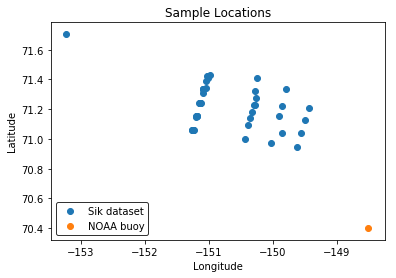

In [18]:
#Plot the sample locations as well as the location of the NOAA buoy that gives us the wind
#, air and water data
plt.scatter(Alldata.Longitude,Alldata.Latitude)
plt.scatter(-148.52,70.4)
plt.title('Sample Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(('Sik dataset','NOAA buoy'), edgecolor='k',loc='lower left')

As seen in the figure above, the datset covers a good sized area. In the following figures, I'll be looking at if the area sampled is a good representation of that part of the Beaufort Sea.

In [19]:
#import basemap plotting package
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

In [21]:
#Buoy data from Austin is read in here.
infile = 'Buoy6_Abbot.csv'
buoyAbbot = pd.read_csv(infile, sep = (','))
#list(buoyAbbot.columns)

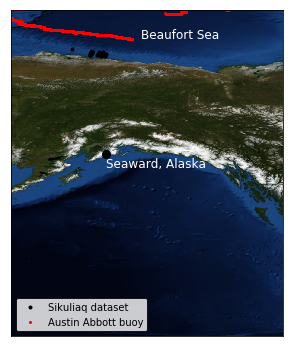

In [22]:
#Plot a large scale map of Alaska showing my dataset as well as Austin's buoy
#Add local destinations to visualize
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,llcrnrlat=40, urcrnrlat=76,llcrnrlon=-160, urcrnrlon=-130, )
m.bluemarble(scale=2)
#With all data to be plotted make them map readable:
x, y = m(Alldata.Longitude,Alldata.Latitude)
plt.plot(x, y, 'ok', markersize=3)
x1,y1 = m(buoyAbbot.GPSLongitude,buoyAbbot.GPSLatitude)
plt.plot(x1,y1,'or',markersize=2)
x2, y2 = m(-149.4422, 60.1042)
plt.plot(x2, y2, 'ok', markersize=8)
plt.text(x2, y2-1.5, 'Seaward, Alaska', fontsize=12,color='w')
x3, y3 = m(-145.5685, 72.8431)
#plt.plot(x3, y3, 'ok', markersize=5)
plt.text(x3, y3, 'Beaufort Sea', fontsize=12,color='w')
plt.legend(('Sikuliaq dataset','Austin Abbott buoy'), edgecolor='k',loc='lower left')

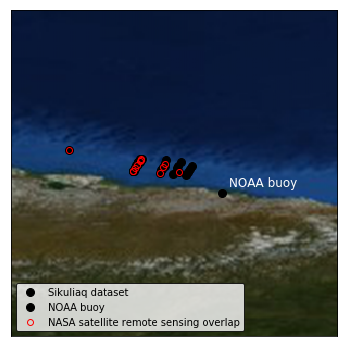

In [23]:
#Zoom in on above map to look closer at the coverage of my dataset
fig = plt.figure(figsize=(8, 6), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,llcrnrlat=66, urcrnrlat=76,llcrnrlon=-155, urcrnrlon=-145, )
m.bluemarble(scale=2)
x, y = m(Alldata.Longitude,Alldata.Latitude)
plt.plot(x, y, 'ok', markersize=8)
x1,y1 = m(-148.52,70.4)
plt.plot(x1,y1,'ok',markersize=8)
plt.text(x1+0.2, y1+0.2, 'NOAA buoy', fontsize=12,color='w')
x2,y2 = m(DataSatallite.Longitude,DataSatallite.Latitude)
plt.plot(x2,y2,'o', ms=6, markerfacecolor="None", markeredgecolor='red', markeredgewidth=1)
plt.legend(('Sikuliaq dataset','NOAA buoy','NASA satellite remote sensing overlap'), edgecolor='k',loc='lower left')

The following code is partially taken from matplotlib.org: https://matplotlib.org/3.2.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html

I use it to plot multiple y axis on one plot to take a look at the variables that I have along with my own data.

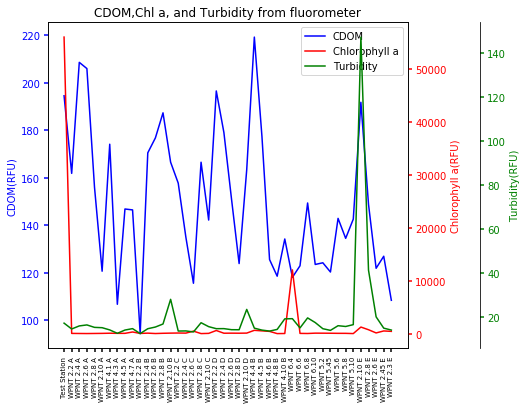

In [24]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)
#Adjust figure size
fig.set_figheight(6)
fig.set_figwidth(8)
par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.2))
#make spine connecting axis invisible
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)
#Plot each variable on it's own axis
p1, = host.plot(Alldata['Description'], Alldata['CDOM(RFU)'], "b-", label="CDOM")
p2, = par1.plot(Alldata['Description'], Alldata['Chlorophyll_a(RFU)'], "r-", label="Chlorophyll a")
p3, = par2.plot(Alldata['Description'], Alldata['Turbidity(RFU)'], "g-", label="Turbidity")
#Axis limits
#host.set_xlim(0, 2)
#host.set_ylim(0, 2)
#par1.set_ylim(0, 10000)
#par2.set_ylim(1, 65)
#host.set_xlabel("Waypoint")
host.set_ylabel("CDOM(RFU)")
par1.set_ylabel("Chlorophyll a(RFU)")
par2.set_ylabel("Turbidity(RFU)")
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
tkw = dict(size=4, width=1.5)
#Tick parameters
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x',labelrotation=90,labelsize=7, **tkw)
lines = [p1, p2, p3]
host.legend(lines, [l.get_label() for l in lines])
host.title.set_text("CDOM,Chl a, and Turbidity from fluorometer")
plt.show()

In the figure above, we can see that there two major outliers skewing the figure. Chlorophyll at "Test Station" and Turbidity at "WPNT 2.10E".
The "Test Station" Chl a outlier may be due to the instrument having just been turned on during the start of the cruise. I may change that value to a NaN or at least look closer at the surrounding fluorometer data during that sampling time.
The "Turbidity" outlier at "WPNT 2.10E" may be due to it being very close to the coast with a  bottom depth of 11m.

The following cell will be exactly the same as for the figure above, except with contrained limits to look at the variability of Chlorophyll a and Turbidity more closely.

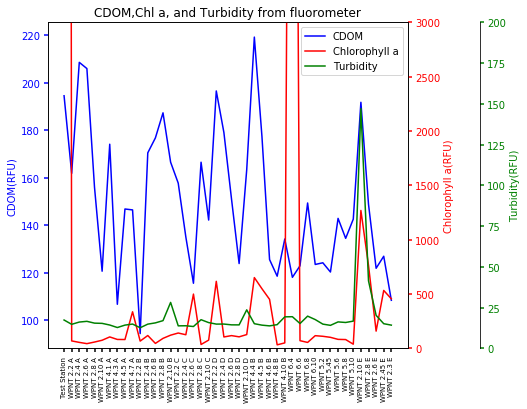

In [25]:
fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)
#Adjust figure size
fig.set_figheight(6)
fig.set_figwidth(8)
par1 = host.twinx()
par2 = host.twinx()
par2.spines["right"].set_position(("axes", 1.2))
#make spine connecting axis invisible
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)
#Plot each variable on it's own axis
p1, = host.plot(Alldata['Description'], Alldata['CDOM(RFU)'], "b-", label="CDOM")
p2, = par1.plot(Alldata['Description'], Alldata['Chlorophyll_a(RFU)'], "r-", label="Chlorophyll a")
p3, = par2.plot(Alldata['Description'], Alldata['Turbidity(RFU)'], "g-", label="Turbidity")
#host.set_xlim(0, 2)
#host.set_ylim(0, 2)
par1.set_ylim(0, 3000)
par2.set_ylim(0, 200)
#host.set_xlabel("Waypoint")
host.set_ylabel("CDOM(RFU)")
par1.set_ylabel("Chlorophyll a(RFU)")
par2.set_ylabel("Turbidity(RFU)")
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x',labelrotation=90,labelsize=7, **tkw)
lines = [p1, p2, p3]
host.legend(lines, [l.get_label() for l in lines])
host.title.set_text("CDOM,Chl a, and Turbidity from fluorometer")
plt.show()

There is definitely a moderate amount of variability in the dataset. So, I expect that the data is a good representation of this study area. It doesn't seem that using this data will over train the model towards a certain type of environment seen in the geographic area.

Text(0.5,1,'T-S diagram')

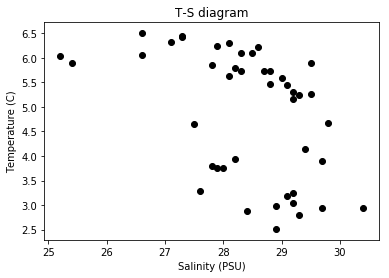

In [26]:
#Plot a T-S scatter plot
plt.scatter(Alldata['Salinity (PSU)'],Alldata['Temp(C)'],color = 'k')
plt.xlabel('Salinity (PSU)')
plt.ylabel('Temperature (C)')
plt.title('T-S diagram')

The distribution of the stations that were sampled seem to be have covered a wide range of water masses. This also supports the statement in the cell above that the dataset covers a wide range and hopefully will not be overtrained on a certain type of water mass.

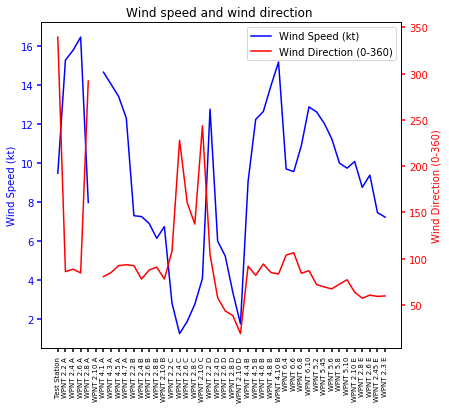

In [27]:
#Plot the wind speed and wind direction from the NOAA buoy
fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)
#Adjust figure size
fig.set_figheight(6)
fig.set_figwidth(8)
par1 = host.twinx()


#make spine connecting axis invisible


#Plot each variable on it's own axis
p1, = host.plot(Alldata['Description'], Alldata['WSPD'], "b-", label="Wind Speed (kt)")
p2, = par1.plot(Alldata['Description'], Alldata['WDIR'], "r-", label="Wind Direction (0-360)")
#host.set_xlim(0, 2)
#host.set_ylim(0, 2)
#par1.set_ylim(0, 3000)
#host.set_xlabel("Waypoint")
host.set_ylabel("Wind Speed (kt)")
par1.set_ylabel("Wind Direction (0-360)")
host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
host.tick_params(axis='x',labelrotation=90,labelsize=7, **tkw)
lines = [p1, p2]
host.legend(lines, [l.get_label() for l in lines])
host.title.set_text("Wind speed and wind direction ")
plt.show()

The wind data shows a gap at WPNT 2.10 A, which may be due to the buoy not having data but if it is the case of the time interval I captured for each sampling point I may increase the interval. 
The wind speed shows an increase several times and the wind direction changes from east to west twice. So hopefully the water masses sampled are well mixed and again doesn't overtrain the model.

The dataset is plotted here along with the buoy data from Austin to see if there is any overlap. As seen in the figure, there is no overlap but it is close. The reason I'm including it is because I want to run the model on the buoy data from Austin just to see what the result would look like. I have no way to confirm validity but I want to see what future results could look like if we collaberate with other groups that have buoy data that overlaps with my dataset.

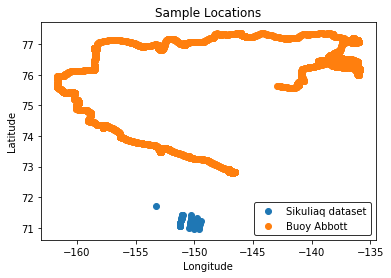

In [28]:
#buoyAbbot = pd.concat([Alldata, SikLog], axis=1)
plt.scatter(Alldata.Longitude,Alldata.Latitude)
plt.scatter(buoyAbbot.GPSLongitude,buoyAbbot.GPSLatitude)
plt.title('Sample Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(('Sikuliaq dataset','Buoy Abbott'), edgecolor='k',loc='lower right')

In class we have had examples of two different data sets that we had the model output variable for. Such that we could train our model on one set of data and validate it on another set of data (JMA vs Argo, for example). 
I don't have overlap in this sense. I'll be using remote sensing data from NASA (SST,SSS) that was measured at the same time and coordinates as my samples were collected. Thus, I'll be looking at how reliable the model output using the remote sensing variables as input variables after being trained on my own dataset.


Finally, the dataset shows a fair amount of variability in the environmental data that will be used to train the model. So, I feel confident that the dataset will not overly train the model towards one specific water mass. 
In the future, hopefully we'll be able to expand this project to include datasets with more overlap and in an area covered better by remote sensing.